In [1]:
# ================================
# Standard library
# ================================
import importlib
import os
import sys

# ================================
# Third-party libraries
# ================================
import joblib
import pandas as pd

# ================================
# Project configuration
# ================================
# Aggiungi la root del progetto al PYTHONPATH
sys.path.append(os.path.abspath(".."))

In [2]:
# Converts relative paths to absolute ones
ROOT_TRAIN_DATA_FOLDER ='data/raw/B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data'
ROOT_TEST_DATA_FOLDER = 'data/raw/B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_test_data'

## Parsing

In [ ]:
import utils.parsing
importlib.reload(utils.parsing)
from utils.parsing import parse_phm_dataset_comprehensive

df= parse_phm_dataset_comprehensive(ROOT_TRAIN_DATA_FOLDER)
test_df= parse_phm_dataset_comprehensive(ROOT_TEST_DATA_FOLDER)
""" df = parse_vibration_dataset(ROOT_TRAIN_DATA_FOLDER)
test_df = parse_test_dataset(ROOT_TEST_DATA_FOLDER)
 """

Trovati 2016 file .txt da processare


Parsing dataset: 100%|██████████| 2016/2016 [01:23<00:00, 24.02file/s]



Ordinamento dataset...
Dataset caricato: 2016 file processati
Health levels disponibili: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(8)]
Condizioni operative (rpm): [np.int64(100), np.int64(200), np.int64(300), np.int64(400), np.int64(500), np.int64(600), np.int64(700), np.int64(800), np.int64(900), np.int64(1000), np.int64(1200), np.int64(2100), np.int64(2700), np.int64(3000), np.int64(3600)]
Condizioni operative (torque): [np.int64(50), np.int64(100), np.int64(200), np.int64(300), np.int64(400), np.int64(500)]
Trovati 800 file .txt da processare


Parsing dataset: 100%|██████████| 800/800 [00:31<00:00, 25.62file/s]


Ordinamento dataset...
Dataset caricato: 800 file processati
Condizioni operative (rpm): [np.int64(100), np.int64(200), np.int64(300), np.int64(400), np.int64(500), np.int64(600), np.int64(700), np.int64(800), np.int64(900), np.int64(1000), np.int64(1200), np.int64(1500), np.int64(1800), np.int64(2100), np.int64(2400), np.int64(2700), np.int64(3000), np.int64(3600)]
Condizioni operative (torque): [np.int64(50), np.int64(100), np.int64(200), np.int64(300), np.int64(400), np.int64(500)]


In [4]:
df.to_pickle('data/processed/train_data.pkl')
test_df.to_pickle('data/processed/test_data.pkl')

In [5]:
df

,etichetta,health_level,velocita,torque,rep,descrizione,file_name,horizontal_acceleration,axial_acceleration,vertical_acceleration,tachometer_signal,sampling_rate,duration,num_samples
0,0,0,100,50,1,None,V100_50N_1.txt,"[-0.4626018245, -0.7124489885, -0.5509291238, ...","[-0.4991110174, -0.7377190438, -0.5699753646, ...","[-0.4254987892, -0.814484938, -0.5429899587, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784
1,0,0,100,50,2,None,V100_50N_2.txt,"[0.08373725705, -0.01240551956, -0.05421212049...","[0.04308363971, -0.05226539899, -0.09993991833...","[0.0949569657, -0.06374649093, -0.1336386738, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784
2,0,0,100,50,3,None,V100_50N_3.txt,"[-0.06376437055, 0.09676305259, -0.04503203601...","[-0.07804495389, 0.07745637958, -0.06497860415...","[-0.0985720786, 0.153401291, -0.08254507805, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784
3,0,0,100,50,4,None,V100_50N_4.txt,"[0.07418500699, -0.03634817232, -0.08572214018...","[0.06933405406, -0.03107672372, -0.07251235535...","[0.1519552459, -0.01518347421, -0.08507565708,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784
4,0,0,100,50,5,None,V100_50N_5.txt,"[-0.02816052941, 0.04416364964, 0.05731350038,...","[-0.06439002983, 0.02001152664, 0.03849276007,...","[-0.07965298772, 0.031089971, 0.06398749846, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,8,8,3600,50,4,None,V3600_50N_4.txt,"[1.204451865, -0.1957590936, 1.235341629, -1.1...","[1.470023222, -0.8547275853, -0.1185388638, -0...","[-0.2483582682, 0.8396702352, -0.792673769, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,3.10,63488
2012,8,8,3600,50,5,None,V3600_50N_5.txt,"[1.101238001, 0.3900295435, -1.069976069, -1.8...","[1.060493153, -1.009287271, -4.564982457, -1.4...","[-0.6602401272, -3.394470434, -2.691933483, -3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,3.10,63488
2013,8,8,3600,100,1,None,V3600_100N_1.txt,"[0.608738855, -0.1899285095, -0.6275952358, -0...","[-1.434473347, -1.787617828, -0.008240040596, ...","[-1.747907112, 0.2680003619, 1.120082469, 0.63...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,3.10,63488
2014,8,8,3600,100,3,None,V3600_100N_3.txt,"[0.8193845561, -2.331245204, -0.7011599726, 0....","[-3.238924463, 0.9797407888, 4.608772326, 2.40...","[-0.207507493, 1.852865794, -0.4973190346, 0.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,3.10,63488


In [6]:
test_df

,id,velocita,torque,file_name,horizontal_acceleration,axial_acceleration,vertical_acceleration,tachometer_signal,sampling_rate,duration,num_samples
0,703,100,50,703_V100_50N.txt,"[-0.0793953252, 0.01252957476, -0.000744331173...","[-0.04437850319, 0.02966414537, -0.01106519708...","[-0.08579867966, 0.01337591776, 0.002410075271...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784
1,711,100,50,711_V100_50N.txt,"[0.01116496761, 0.0425509321, 0.05830594195, -...","[-0.002001152664, 0.03166529804, 0.04790994907...","[-0.01903959464, 0.01807556454, 0.04410437747,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.10,247808
2,457,100,50,457_V100_50N.txt,"[0.004465987043, 0.1771508194, -0.1422913094, ...","[0.007533751205, 0.1839883302, -0.1688031129, ...","[-0.03494609144, 0.339941117, -0.3786228251, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784
3,793,100,50,793_V100_50N.txt,"[0.04850558058, -0.03783683449, 0.06823035918,...","[0.06662661062, -0.03084129268, 0.07863353087,...","[0.08567817367, -0.05952885841, 0.1018256829, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.10,247808
4,271,100,50,271_V100_50N.txt,"[0.2159800956, -0.1896803941, 0.1527119458, 0....","[0.1872843464, -0.207295873, 0.1283092002, 0.0...","[0.2712539718, -0.2947522057, 0.1764175099, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784
...,...,...,...,...,...,...,...,...,...,...,...
795,264,3600,100,264_V3600_100N.txt,"[1.576245316, 1.086723514, -1.176663531, 0.925...","[3.354520439, -1.617873071, -2.713798442, -3.0...","[2.894741409, -1.21636499, -3.337954251, -5.58...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,3.05,62464
796,453,3600,100,453_V3600_100N.txt,"[0.1532081609, 0.4066529222, -1.364731174, 1.8...","[-0.8925140607, 1.809512957, 4.169107232, 2.81...","[-1.313852531, -0.9281199505, 1.519913926, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",20480,3.10,63488
797,767,3600,100,767_V3600_100N.txt,"[-2.415726825, -0.6532746602, -2.051624825, 0....","[-3.742861771, -0.6247127757, 4.073875964, 4.9...","[-1.370007288, -0.5115384764, 1.709707398, 4.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,3.05,62464
798,424,3600,100,424_V3600_100N.txt,"[-0.7935810902, -0.08572214179, -0.3430126066,...","[-3.753691439, -3.554753342, 0.4637965798, 1.0...","[-2.658072022, -0.5703442897, 1.294330927, 1.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,3.10,63488


In [ ]:
df['health_level'] = pd.to_numeric(df['health_level'], errors='coerce')
df_clean = df.dropna(subset=['health_level']).reset_index(drop=True)
y = df_clean['health_level']

# Feature Extraction

In [ ]:
import utils.feature_extraction
importlib.reload(utils.feature_extraction)
from utils.feature_extraction import expand_features

X_features = expand_features(df_clean)

NameError: name 'importlib' is not defined

## EDA

In [ ]:
import utils.eda
importlib.reload(utils.eda)
from utils.eda import comprehensive_dataset_analysis

comprehensive_dataset_analysis(df_clean, X_features, y)

## Feature Selection

In [ ]:
import utils.feature_selection
importlib.reload(utils.feature_selection)
from utils.feature_selection import plot_correlation_matrix_full, remove_multicollinearity, conservative_feature_selection, visualize_conservative_selection

# 1. Mostra matrice COMPLETA prima
plot_correlation_matrix_full(X_features, 
                        title="PRIMA della rimozione multicollinearità",
                        threshold=0.85)

# Step 1: Rimuovi multi-collinearità (threshold permissivo)
X_no_multicoll, removed_multicoll = remove_multicollinearity(X_features, threshold=0.85)

# 3. Mostra matrice COMPLETA dopo
plot_correlation_matrix_full(X_no_multicoll,
                        title="DOPO rimozione multicollinearità", 
                        threshold=0.85)

# Step 2: Selezione conservativa multi-metodo
selected_features, selection_scores = conservative_feature_selection(
    X_no_multicoll, 
    y, 
    min_features=40  # Mantieni almeno 40 features per robustezza
)

# Features finali
X_selected = X_no_multicoll[selected_features]

# Step 3: Visualizza il processo
visualize_conservative_selection(X_no_multicoll, X_selected, selection_scores, y)

print(f"\n📋 RIEPILOGO SELEZIONE:")
print(f"   • Features iniziali: {len(X_features.columns)}")
print(f"   • Dopo rimozione multi-collinearità: {len(X_no_multicoll.columns)}")
print(f"   • Features finali (Conservative): {len(X_selected.columns)}")
print(f"   • Features domain-critical mantenute: {sum(selection_scores['aggregate_scores']['is_critical'])}")

## Downsampling

In [7]:
df = pd.read_pickle('data/processed/train_data.pkl')

In [8]:
import utils.downsampling
importlib.reload(utils.downsampling)
from utils.downsampling import downsample_vibration_dataframe


features_df = downsample_vibration_dataframe(df, sec=3)

Preprocessing:   0%|          | 0/2016 [00:00<?, ?it/s]

Preprocessing: 100%|██████████| 2016/2016 [00:00<00:00, 27923.89it/s]


In [3]:
features_df.to_pickle('data/processed/train_data_dowsampled.pkl')

NameError: name 'features_df' is not defined

## Feature extraction

In [3]:
features_df = pd.read_pickle("data/processed/train_data_dowsampled.pkl")

In [4]:
# -----------------------
# Pulizia base target
# -----------------------
features_df['health_level'] = pd.to_numeric(features_df['health_level'], errors='coerce')
features_df = features_df.dropna(subset=['health_level']).reset_index(drop=True)

# -----------------------
# Definisci colonne
# -----------------------
scalar_cols = ['velocita', 'torque']  # numeriche scalari già pronte
array_cols = ['horizontal_acceleration', 'axial_acceleration', 'vertical_acceleration', 'tachometer_signal']

scalar_cols = [c for c in scalar_cols if c in features_df.columns]
array_cols  = [c for c in array_cols  if c in features_df.columns]

In [5]:
import utils.feature_extraction
importlib.reload(utils.feature_extraction)
from utils.feature_extraction import expand_features, remove_multicollinearity

print("[*] Genero feature...")
X_with_features = expand_features(features_df, array_cols=array_cols, scalar_cols=scalar_cols)
y = features_df['health_level'].astype(float).values

X_with_features, dropped_cols = remove_multicollinearity(X_with_features, threshold=0.85)

print(f"[*] Shape X_with_features: {X_with_features.shape}, n_features = {X_with_features.shape[1]}")

[*] Genero feature...

📊 Rimozione multi-collinearità (threshold=0.85)...
   • Features iniziali: 75
   • Features rimosse: 39
   • Features rimanenti: 36
[*] Shape X_with_features: (2016, 36), n_features = 36


In [13]:
X_with_features

,ax_median,ax_skew,ax_kurt,ax_band_0_200,ax_band_200_500,ax_band_500_1000,ax_band_1000_2000,ax_band_2000_4000,ay_median,ay_skew,...,corr_xz,corr_yz,ipi_mean,ipi_std,ipi_cv,v_times_t,v_sq,t_sq,v_over_rpm,t_over_rpm
0,-0.136461,-0.776361,0.005485,0.008149,0.010712,0.015578,0.009459,0.022354,-0.151264,-0.770164,...,0.976064,0.971404,1.082007,0.000659,0.000609,5000,10000,2500,1.666667,0.833333
1,0.003846,-0.272321,-0.881175,0.006527,0.011009,0.015855,0.009479,0.021377,0.003531,-0.277709,...,0.978543,0.979238,1.082153,0.000220,0.000203,5000,10000,2500,1.666667,0.833333
2,0.003598,-0.276468,-0.882501,0.005376,0.010446,0.014623,0.008646,0.022393,0.003885,-0.290422,...,0.979485,0.979838,1.081201,0.000000,0.000000,5000,10000,2500,2.500000,1.250000
3,0.003101,-0.275950,-0.891065,0.006446,0.009653,0.014769,0.009171,0.021920,0.003296,-0.285690,...,0.980113,0.980239,1.082666,0.000000,0.000000,5000,10000,2500,2.500000,1.250000
4,0.003722,-0.278965,-0.880287,0.007915,0.009939,0.014594,0.008473,0.022195,0.003767,-0.286163,...,0.980032,0.980720,1.082373,0.000195,0.000180,5000,10000,2500,1.666667,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,0.005645,-0.013527,0.140991,0.002078,0.004298,0.036616,0.042241,0.306010,0.040200,-0.079874,...,-0.013338,0.307308,0.030001,0.000024,0.000802,180000,12960000,2500,1.800000,0.025000
2012,0.001116,-0.021760,0.110431,0.001955,0.004792,0.035701,0.042614,0.307787,0.039552,-0.065825,...,-0.001688,0.304524,0.030002,0.000024,0.000807,180000,12960000,2500,1.800000,0.025000
2013,0.004094,0.018121,0.038303,0.000846,0.003244,0.027520,0.069767,0.468692,-0.272392,0.226129,...,0.066381,0.463836,0.030002,0.000024,0.000807,360000,12960000,10000,1.800000,0.050000
2014,0.003349,0.019681,0.091883,0.000803,0.003702,0.029189,0.074510,0.469177,-0.256501,0.229332,...,0.048462,0.418718,0.030001,0.000024,0.000804,360000,12960000,10000,1.800000,0.050000


In [15]:
X_with_features.to_pickle('data/processed/X_with_features.pkl')

In [ ]:
X_with_features = pd.read_pickle('data/processed/X_with_features.pkl')

## Training

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# -----------------------
# Split
# -----------------------
y_int = y.astype(int)
X = X_with_features.astype(np.float32).values

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_int
)

print(f"Dataset: {len(y)} campioni, {X.shape[1]} features, {len(set(y))} classi")
print(f"Split: Train={len(y_tr)}, Val={len(y_va)}")

Dataset: 2016 campioni, 36 features, 7 classi
Split: Train=1612, Val=404


In [15]:
import utils.model_class
importlib.reload(utils.model_class)
from utils.model_class import ModelSelectorClassification

# 3. Inizializza e addestra il selettore
selector = ModelSelectorClassification(
    scoring="f1_macro",  # Usa F1 macro per classi sbilanciate
    cv_folds=3,
    random_state=42
)

# 4. Training di tutti i modelli
selector.fit(X_tr, y_tr, X_with_features.columns.tolist())

TRAINING MODELLI (Classificazione)
⚠️  ATTENZIONE: all_classes non specificato.
   I modelli conosceranno solo le classi presenti nel training.
   Classi trovate: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(6.0), np.float64(8.0)]

📈 Configurazione modelli per 7 classi totali

🚀 Avvio training di 8 modelli...
------------------------------------------------------------

[*] Tuning RandomForest...


Tuning RandomForest: 675it [00:27, 24.26it/s]                       


[+] Best F1_MACRO (cv) RandomForest: 0.9295
[+] Best params RandomForest:
{'model__class_weight': None,
 'model__max_depth': None,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 600}

[*] Tuning HistGradientBoosting...


Tuning HistGradientBoosting: 111it [01:09,  1.60it/s]                       


[+] Best F1_MACRO (cv) HistGradientBoosting: 0.9262
[+] Best params HistGradientBoosting:
{'model__l2_regularization': 0.1,
 'model__learning_rate': 0.1,
 'model__max_depth': 8,
 'model__max_iter': 800,
 'model__min_samples_leaf': 30}

[*] Tuning XGBoost...


Tuning XGBoost: 100%|██████████| 90/90 [00:30<00:00,  2.93it/s]


[+] Best F1_MACRO (cv) XGBoost: 0.9180
[+] Best params XGBoost:
{'model__colsample_bytree': 0.9,
 'model__learning_rate': 0.1,
 'model__max_depth': 8,
 'model__n_estimators': 200,
 'model__reg_alpha': 0,
 'model__reg_lambda': 1.5,
 'model__subsample': 0.8}

[*] Tuning LightGBM...


Tuning LightGBM:   0%|          | 0/90 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Tuning LightGBM:   1%|          | 1/90 [00:23<34:57, 23.57s/it]/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Tuning LightGBM:   2%|▏         | 2/90 [00:24<14:46, 10.07s/it]/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Tuning LightGBM:   3%|▎         | 3/90 [00:24<08:06,  5.59s/it]/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
 

[+] Best F1_MACRO (cv) LightGBM: 0.9307
[+] Best params LightGBM:
{'model__class_weight': None,
 'model__colsample_bytree': 0.8,
 'model__learning_rate': 0.1,
 'model__max_depth': -1,
 'model__n_estimators': 600,
 'model__num_leaves': 31,
 'model__reg_alpha': 0,
 'model__reg_lambda': 0,
 'model__subsample': 0.9}

[*] Tuning GradientBoosting...


Tuning GradientBoosting: 100%|██████████| 75/75 [01:20<00:00,  1.07s/it]


[+] Best F1_MACRO (cv) GradientBoosting: 0.9395
[+] Best params GradientBoosting:
{'model__learning_rate': 0.1,
 'model__max_depth': 8,
 'model__max_features': 'sqrt',
 'model__n_estimators': 600,
 'model__subsample': 0.8}

[*] Tuning ExtraTrees...


Tuning ExtraTrees: 675it [00:07, 85.28it/s]                       


[+] Best F1_MACRO (cv) ExtraTrees: 0.9426
[+] Best params ExtraTrees:
{'model__class_weight': None,
 'model__max_depth': None,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 600}

[*] Tuning RidgeClassifier...


Tuning RidgeClassifier: 100%|██████████| 30/30 [00:00<00:00, 410.41it/s]


[+] Best F1_MACRO (cv) RidgeClassifier: 0.4986
[+] Best params RidgeClassifier:
{'model__alpha': 0.1, 'model__class_weight': 'balanced'}

[*] Tuning LogReg_ElasticNet...


Tuning LogReg_ElasticNet: 46it [00:09,  4.66it/s]                        


[+] Best F1_MACRO (cv) LogReg_ElasticNet: 0.6643
[+] Best params LogReg_ElasticNet:
{'model__C': 10.0, 'model__class_weight': 'balanced', 'model__l1_ratio': 0.7}

RISULTATI FINALI - CONFRONTO MODELLI (Cross-Validation)
Modello              Best CV F1_MACRO   Std       
-------------------------------------------------------
RandomForest         0.9295             0.0081    
HistGradientBoosting 0.9262             0.0108    
XGBoost              0.9180             0.0128    


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM             0.9307             0.0066    
GradientBoosting     0.9395             0.0036    
ExtraTrees           0.9426             0.0034    
RidgeClassifier      0.4986             0.0298    
LogReg_ElasticNet    0.6643             0.0310    

🏆 Miglior modello (CV): ExtraTrees (F1_MACRO: 0.9426 ± 0.0034)

✅ TRAINING COMPLETATO


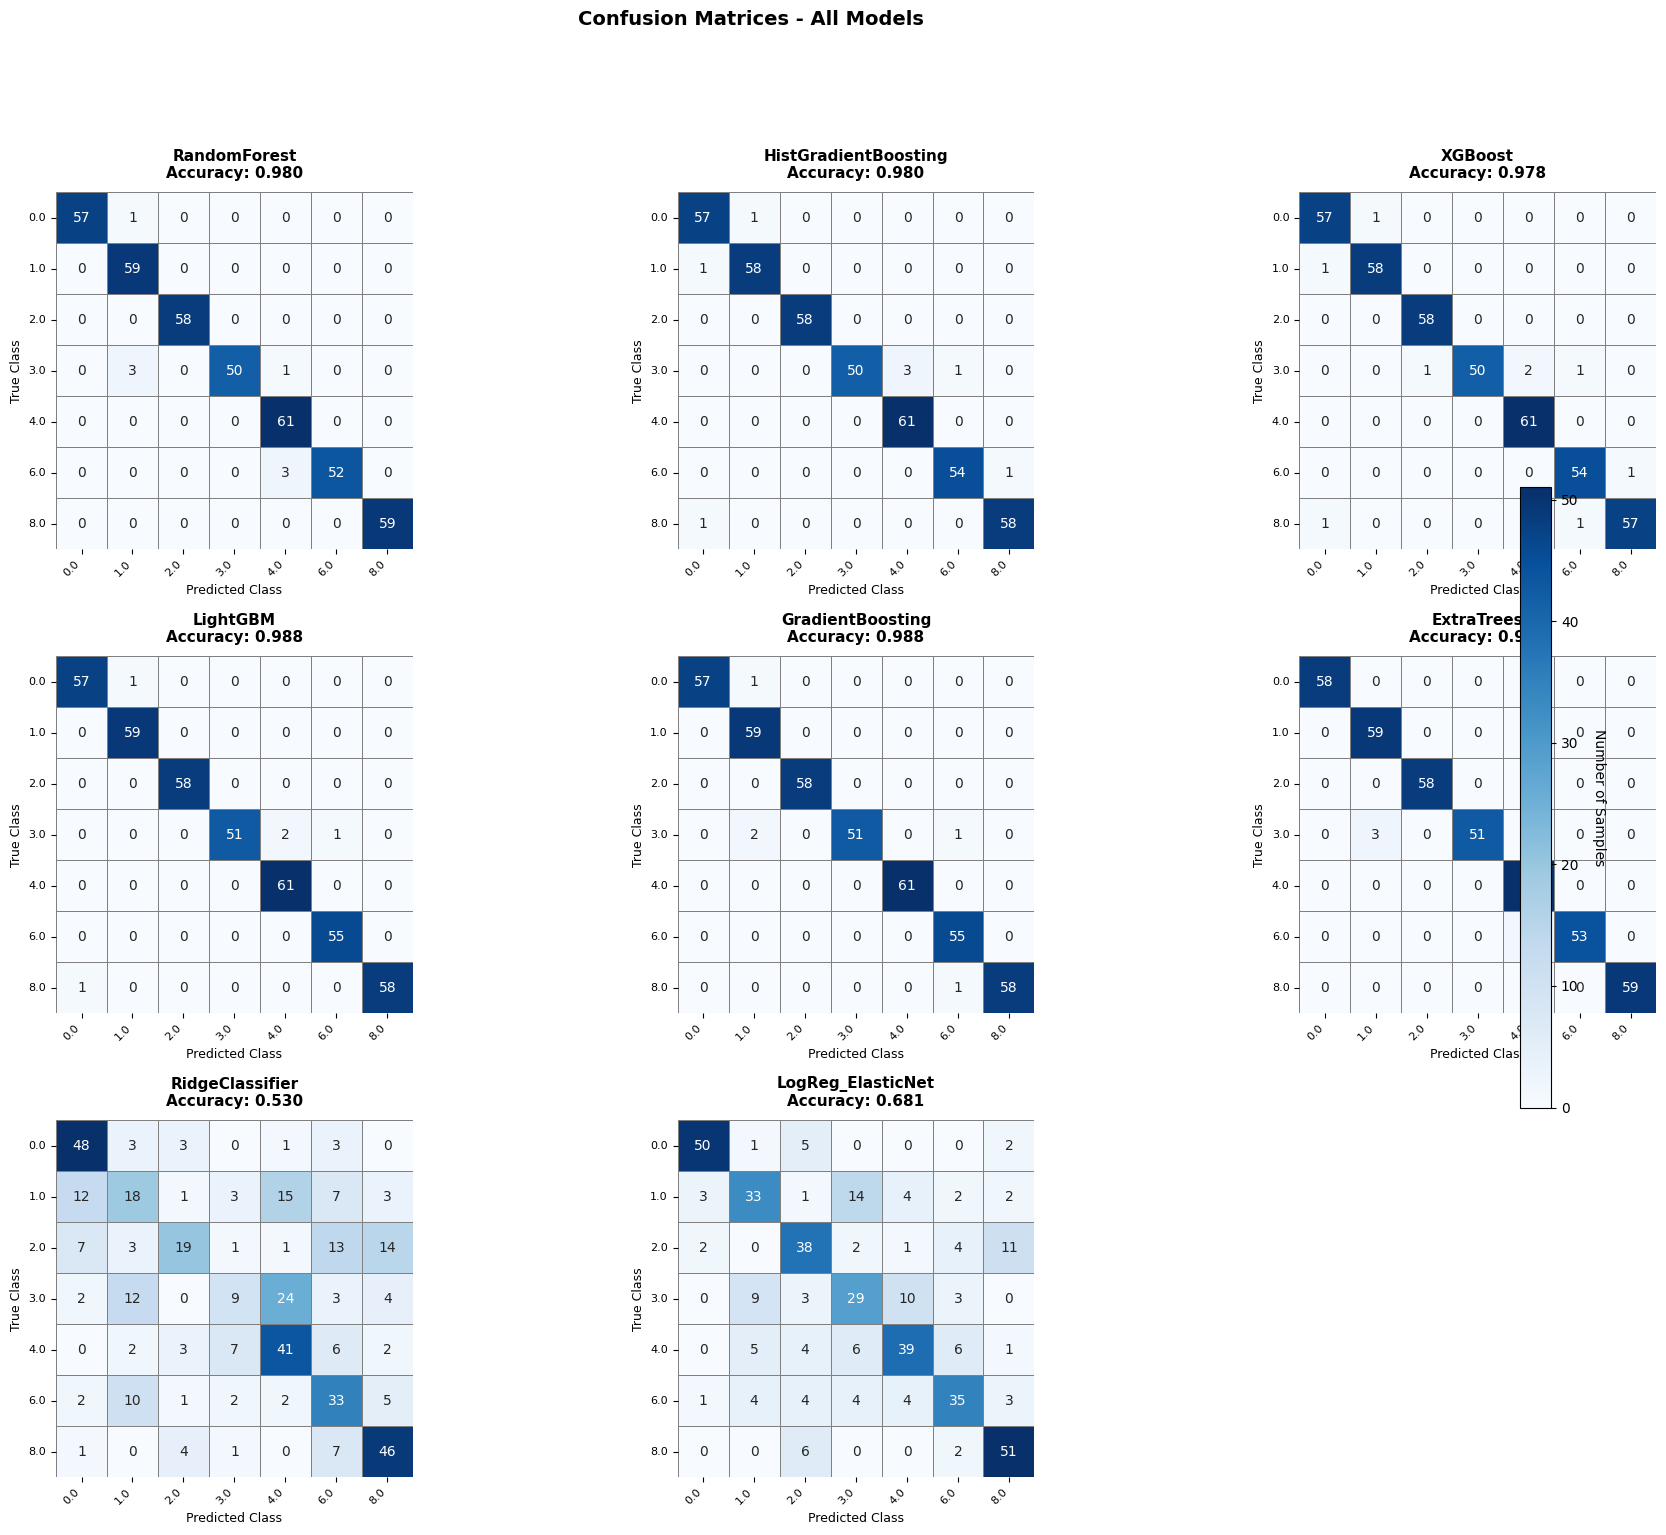

In [18]:
# Visualizza graficamente le confusion matrix
selector.plot_confusion_matrices(figsize=(20, 15))

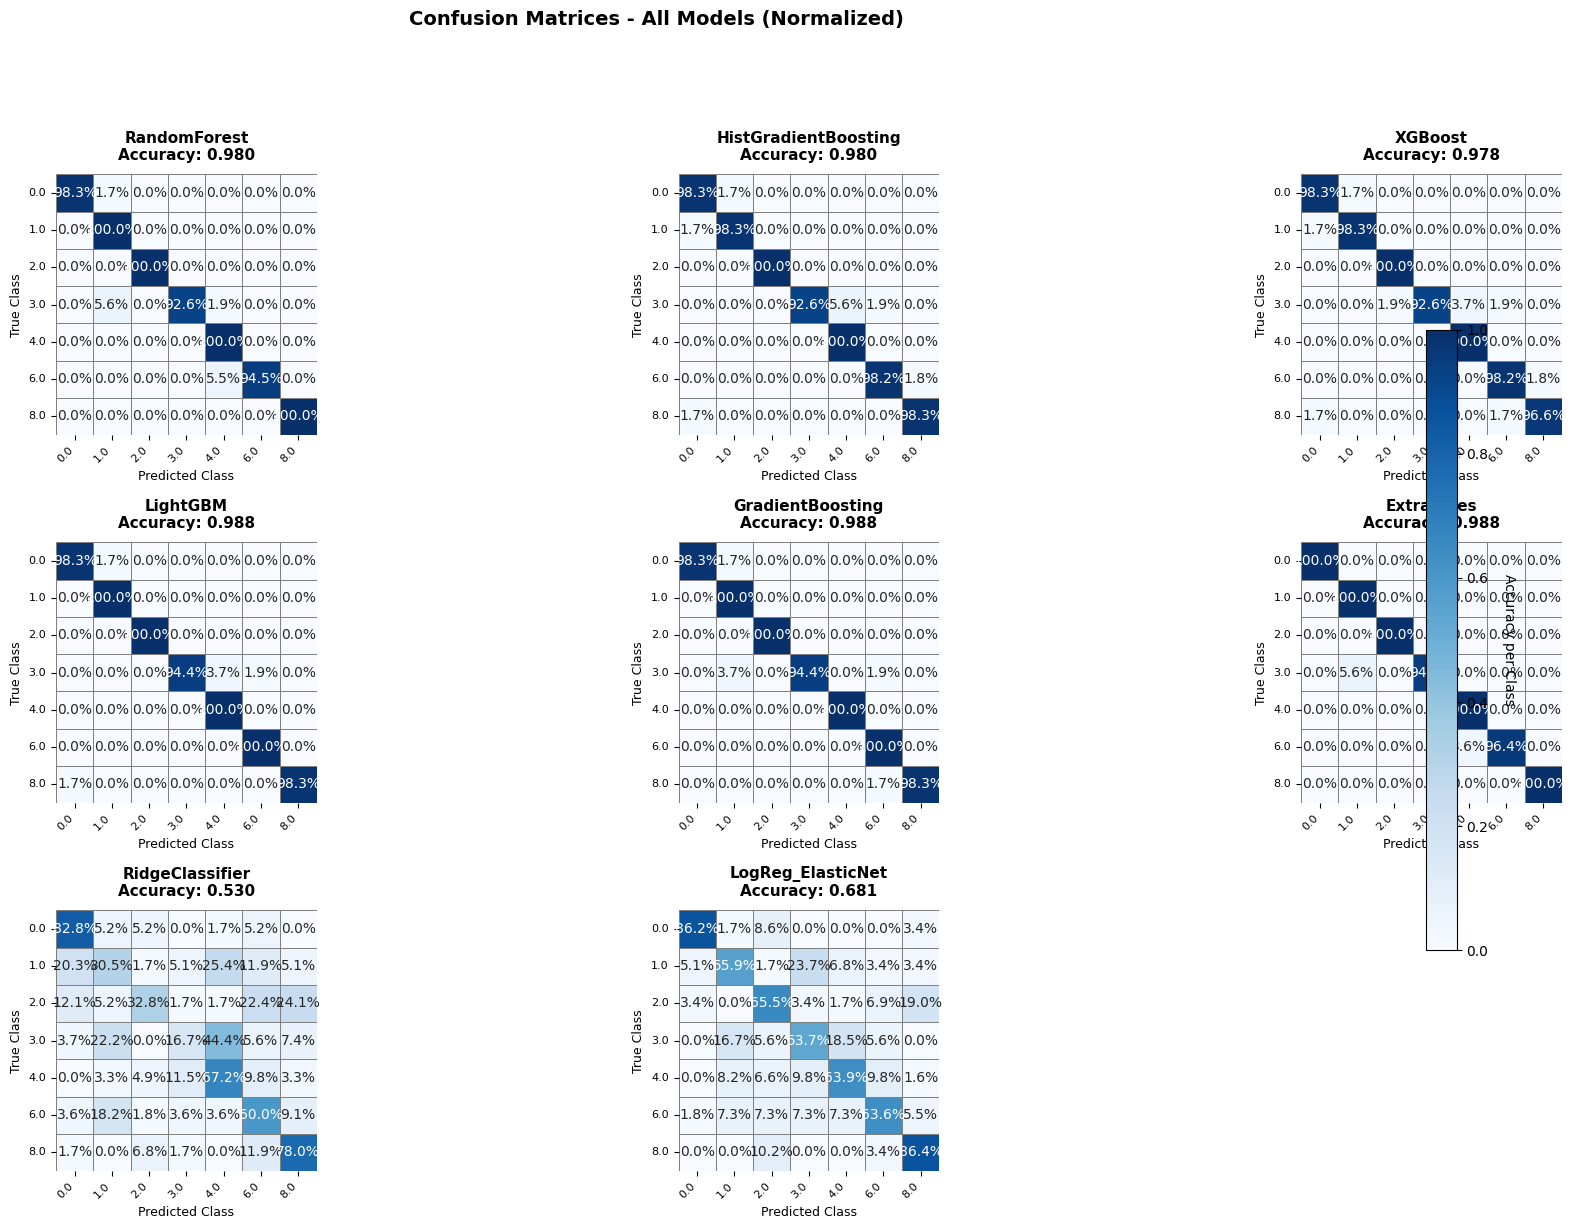

In [19]:
# Visualizza confusion matrices
selector.plot_confusion_matrices(figsize=(20, 12), normalize=True)

In [20]:
# Feature importance
importances = selector.feature_importance(X_va, y_va, n_repeats=10, top_k=10)


[*] Calcolo permutation importance sul modello ExtraTrees...

Top 10 feature (permutation importance - f1_macro):
ipi_cv             0.006994
ay_kurt            0.005489
az_band_200_500    0.003738
corr_xy            0.003656
ipi_std            0.002769
corr_xz            0.002247
ay_skew            0.002238
ax_skew            0.002238
ax_band_0_200      0.001997
ay_band_0_200      0.001720
dtype: float64


In [22]:
# Salvataggio del miglior modello
model_path, metadata_path = selector.save_model()

# Caricamento modello salvato
loaded_model = selector.load_model(model_path, metadata_path)

Modello salvato con joblib in: models/best_model_classification_ExtraTrees_20250907_172755.joblib


ValueError: too many values to unpack (expected 2)

In [23]:
# Creazione di un ensemble dei top 3
ensemble = selector.create_ensemble(top_n=3, voting='soft')

# Addestriamo l’ensemble sulle stesse feature
ensemble.fit(X_tr, y_tr)
print("\nAccuracy ensemble:", ensemble.score(X_va, y_va))


[*] Creato ensemble con soft voting dei top 3 modelli:
  • ExtraTrees
  • GradientBoosting
  • LightGBM

Accuracy ensemble: 0.9900990099009901



PERFORMANCE ENSEMBLE - TOP 3 MODELLI

Classi nel validation set: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(6.0), np.float64(8.0)]
Classi predette dal modello: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(6.0), np.float64(8.0)]

              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000        58
         1.0      0.952     1.000     0.975        59
         2.0      1.000     1.000     1.000        58
         3.0      1.000     0.944     0.971        54
         4.0      0.968     1.000     0.984        61
         6.0      1.000     0.964     0.981        55
         8.0      1.000     1.000     1.000        59

    accuracy                          0.988       404
   macro avg      0.989     0.987     0.987       404
weighted avg      0.988     0.988     0.988       404


SUMMARY METRICHE:
Accuracy:              0.988
Weighted Precision:

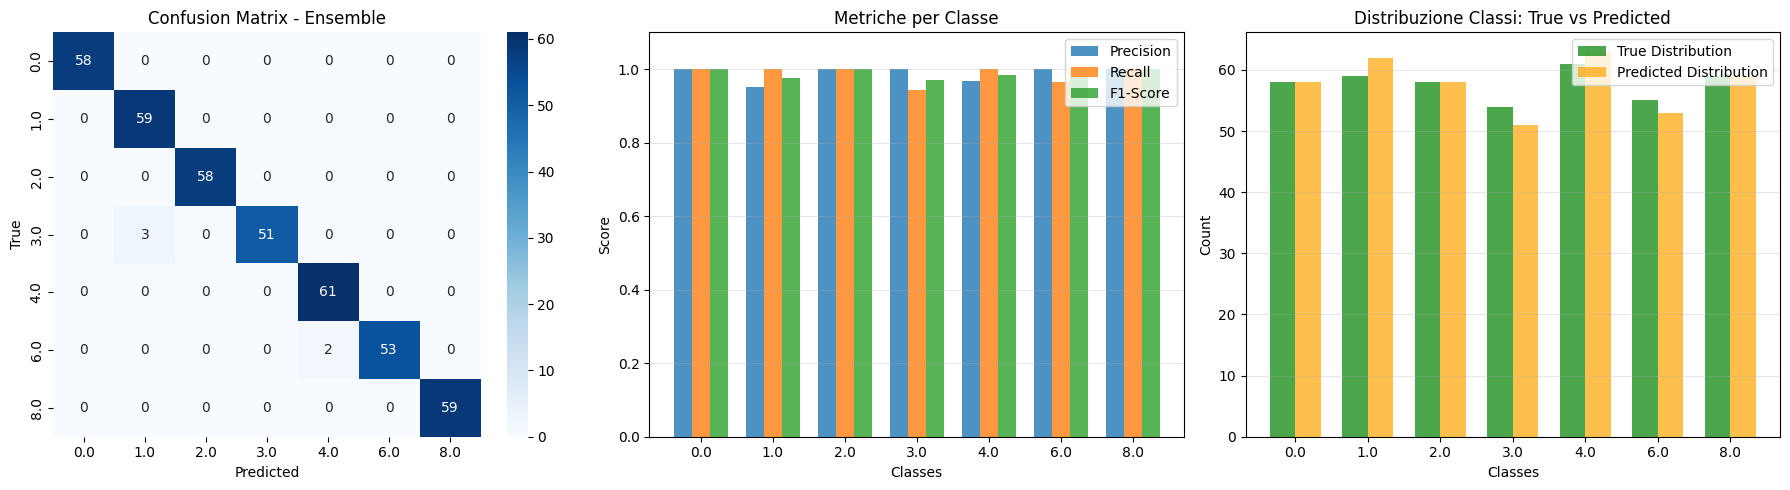

In [24]:
report = selector.evaluate_ensemble(X_va, y_va)

In [25]:
# Salvataggio del miglior modello
model_path_ensamble = selector.save_model(ensemble, model_name="ensemble_model")

Modello salvato con joblib in: models/best_model_classification_ensemble_model_20250907_172831.joblib


In [26]:
# Salva il miglior modello
model_path, metadata_path = selector.save_model()

Modello salvato con joblib in: models/best_model_classification_ExtraTrees_20250907_172836.joblib


ValueError: too many values to unpack (expected 2)

## Soluzione

In [7]:
test_df = pd.read_pickle('data/processed/test_data.pkl')

In [8]:
array_cols = ['horizontal_acceleration', 'axial_acceleration', 'vertical_acceleration', 'tachometer_signal']
scalar_cols = ['velocita', 'torque'] 
X_te = expand_features(test_df, array_cols=array_cols, scalar_cols=scalar_cols)
X_te = X_te.drop(columns=dropped_cols, errors='ignore')

In [14]:
X_te.to_pickle('data/processed/X_te.pkl')

In [ ]:
X_te = pd.read_pickle('data/processed/X_te.pkl')

In [2]:
best_model = joblib.load('models/best_model_classification_ensemble_model_20250829_184740.joblib')

In [ ]:
import utils.submission_generator
importlib.reload(utils.submission_generator)
from utils.submission_generator import SubmissionGenerator

generator = SubmissionGenerator()
submission_df, info = generator.create_submission_simple(
     X_tr, y_tr, X_te, test_df, best_model, conf_thresh=0.6, contamination='auto', alpha=0.8, anomaly_threshold=0.3
 )

# -------------------------
# Risultati
# -------------------------
print("Submission:")
submission_df

c:\Users\dswal\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
c:\Users\dswal\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Using explicit anomaly threshold: 0.4
Submission:


c:\Users\dswal\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,id,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,confidence
0,253,0.005000,1.111131e-03,1.816835e-09,0.058338,3.735535e-01,0.56033,4.340819e-09,0.000000,1.666748e-03,0.000000,0.0,0
1,271,0.006667,9.777774e-01,1.111135e-03,0.014445,1.627159e-08,0.00000,4.407621e-09,0.000000,1.459041e-08,0.000000,0.0,1
2,337,0.046417,1.202970e-02,7.762052e-02,0.005563,2.791986e-03,0.00000,2.746341e-05,0.000000,3.422202e-01,0.513330,0.0,0
3,457,0.001667,2.445729e-09,6.787884e-10,0.017223,9.799988e-01,0.00000,1.503552e-09,0.000000,1.111126e-03,0.000000,0.0,1
4,476,0.009445,9.794437e-01,1.111155e-03,0.010001,1.744047e-08,0.00000,4.665223e-09,0.000000,1.466503e-08,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,264,0.002783,1.111414e-02,2.167306e-02,0.962203,1.114023e-03,0.00000,1.111941e-03,0.000000,3.240597e-07,0.000000,0.0,1
796,424,0.047970,5.411381e-01,5.150737e-02,0.060181,6.246318e-02,0.00000,2.178764e-01,0.000000,1.886454e-02,0.000000,0.0,0
797,453,0.017437,4.322189e-02,4.832170e-02,0.088173,1.625721e-01,0.00000,1.806239e-01,0.000000,1.838601e-01,0.275790,0.0,0
798,506,0.024241,4.580134e-02,3.571775e-02,0.123711,1.485954e-01,0.00000,1.362182e-01,0.204327,1.125551e-01,0.168833,0.0,0


In [48]:
submission_df.to_csv("submission.csv", index=False, encoding="utf-8")

### Results

ANALISI SUBMISSION
📊 STATISTICHE GENERALI:
   • Numero predizioni: 800
   • Normalizzazione: ✅ OK

📈 DISTRIBUZIONE PREDIZIONI:
   • Classe  0:     63 (  7.9%)
   • Classe  1:     91 ( 11.4%)
   • Classe  2:     61 (  7.6%)
   • Classe  3:     60 (  7.5%)
   • Classe  4:     55 (  6.9%)
   • Classe  5:     48 (  6.0%)
   • Classe  6:     99 ( 12.4%)
   • Classe  7:     98 ( 12.2%)
   • Classe  8:    113 ( 14.1%)
   • Classe  9:     50 (  6.2%)
   • Classe 10:     62 (  7.8%)

🔎 CONFIDENCE:
   • High: 436
   • Low : 364
   • Media: 54.5%


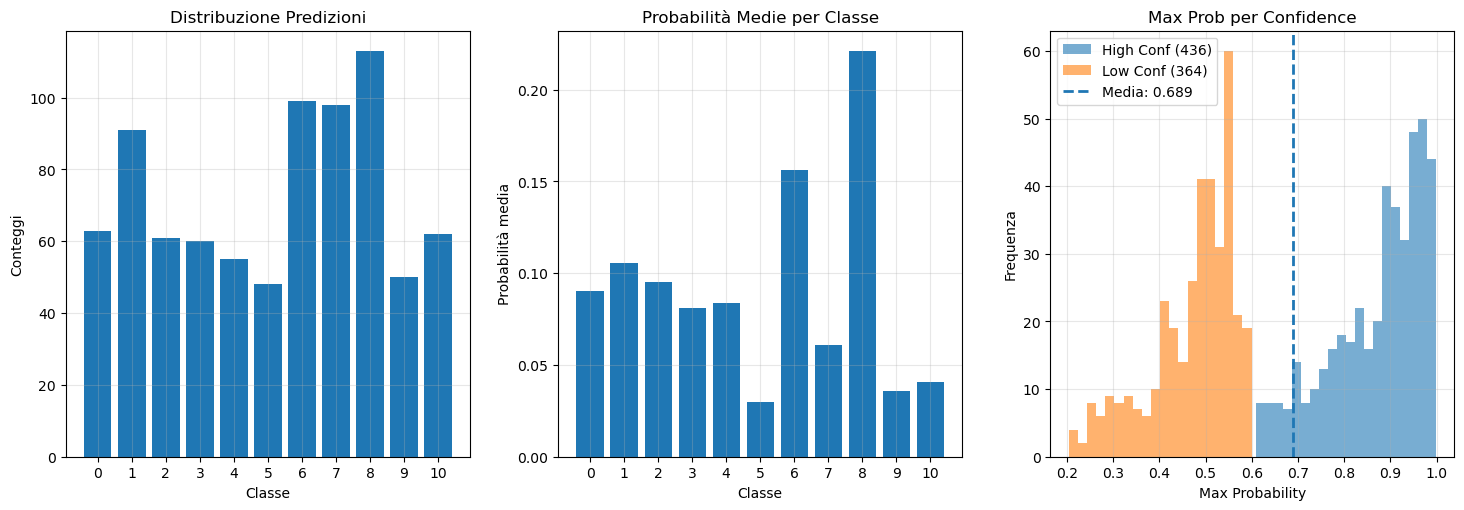

✅ Grafici visualizzati.


In [35]:
import utils.review_results
importlib.reload(utils.review_results)
from utils.review_results import analyze_submission, plot_submission


y_pred, prob_sums = analyze_submission(submission_df)
plot_submission(submission_df, save_path=None)